In [1]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import ResNet50V2

In [2]:
from google.colab import files
files.upload()

Saving kaggle1.json to kaggle1.json


{'kaggle1.json': b'{"username":"safayousuf","key":"e646f30bd4a1b5ff22cf4ce57ec04919"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle1.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle1.json

In [4]:
!kaggle datasets download -d noulam/tomato

Dataset URL: https://www.kaggle.com/datasets/noulam/tomato
License(s): copyright-authors
 98% 729M/743M [00:06<00:00, 132MB/s]
100% 743M/743M [00:06<00:00, 112MB/s]


In [5]:
!unzip tomato.zip

Streaming output truncated to the last 5000 lines.
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train/Tomato___healthy/ac022a2b-764c-4507-8dd9-4470b75763e4___RS_HL 9937.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train/Tomato___healthy/ac249839-fe21-45cd-9e09-f0023fa7ee3a___GH_HL Leaf 273.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train/Tomato___healthy/acdbf632-8d26-472d-874f-6d7df5cd0432___RS_HL 9897.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train/Tomato___healthy/acdf2283-0e7c-4ccd-8817-1019e3a8ed20___RS_HL 9943.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train/Tomato___healthy/acf28842-7821-4f31-ab73-2787e332e852___RS_HL 0011.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train/Tomato___h

In [6]:

valid_dir = '/content/New Plant Diseases Dataset(Augmented)/valid'# Paths to dataset directories
train_dir = '/content/New Plant Diseases Dataset(Augmented)/train'

In [7]:
# Image Data Generator for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1.0/255)

In [8]:
# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 18345 images belonging to 10 classes.
Found 4585 images belonging to 10 classes.


In [9]:
# Load DenseNet121 with pre-trained ImageNet weights
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers to retain pre-trained features
for layer in base_model.layers:
    layer.trainable = False

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [10]:
# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

In [11]:

# Final model
model = Model(inputs=base_model.input, outputs=predictions)

In [12]:

checkpoint = ModelCheckpoint('best_densenet_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')


early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [13]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=valid_generator,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


574/574 ━━━━━━━━━━━━━━━━━━━━ 267s 436ms/step - accuracy: 0.6609 - loss: 1.0024 - val_accuracy: 0.8646 - val_loss: 0.3966
Epoch 2/30
574/574 ━━━━━━━━━━━━━━━━━━━━ 240s 412ms/step - accuracy: 0.8372 - loss: 0.4682 - val_accuracy: 0.8737 - val_loss: 0.3740
Epoch 3/30
574/574 ━━━━━━━━━━━━━━━━━━━━ 241s 415ms/step - accuracy: 0.8654 - loss: 0.3807 - val_accuracy: 0.8918 - val_loss: 0.3209
Epoch 4/30
574/574 ━━━━━━━━━━━━━━━━━━━━ 262s 415ms/step - accuracy: 0.8841 - loss: 0.3361 - val_accuracy: 0.8872 - val_loss: 0.3337
Epoch 5/30
574/574 ━━━━━━━━━━━━━━━━━━━━ 262s 416ms/step - accuracy: 0.8957 - loss: 0.3021 - val_accuracy: 0.8866 - val_loss: 0.3250
Epoch 6/30
574/574 ━━━━━━━━━━━━━━━━━━━━ 241s 414ms/step - accuracy: 0.9074 - loss: 0.2726 - val_accuracy: 0.9226 - val_loss: 0.2292
Epoch 7/30
574/574 ━━━━━━━━━━━━━━━━━━━━ 263s 415ms/step - accuracy: 0.9083 - loss: 0.2611 - val_accuracy: 0.9160 - val_loss: 0.2401
Epoch 8/30
574/574 ━━━━━━━━━━━━━━━━━━━━ 260s 412ms/step - accuracy: 0.9161 - loss: 0.24

In [14]:
model.save('densenet_tomato_leaf__model.h5')

In [1]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt



In [2]:
# Class labels mapping
class_labels = {
    0: 'Tomato___Bacterial_spot',
    1: 'Tomato___Early_blight',
    2: 'Tomato___Late_blight',
    3: 'Tomato___Leaf_Mold',
    4: 'Tomato___Septoria_leaf_spot',
    5: 'Tomato___Spider_mites Two-spotted_spider_mite',
    6: 'Tomato___Target_Spot',
    7: 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
    8: 'Tomato___Tomato_mosaic_virus',
    9: 'Tomato___healthy'
}

In [3]:
# Load the trained model
model = load_model('/content/densenet_tomato_leaf__model.h5')

In [10]:
# Load and preprocess the image
img_path = '/content/diseased.jpg'
img = image.load_img(img_path, target_size=(224, 224))  # Resize to match model input
img_array = image.img_to_array(img) / 255.0  # Normalize to [0, 1]
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

In [11]:
# Make predictions
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)  # Get class index

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


In [12]:
# Map the prediction to the corresponding label
predicted_label = class_labels[predicted_class[0]]


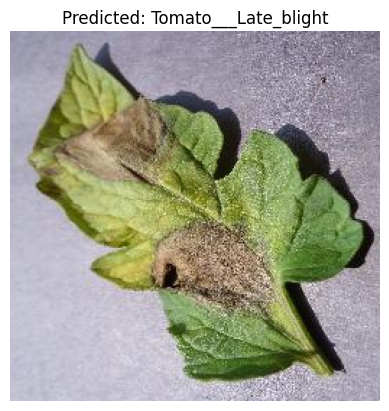

In [13]:
# Display the image with the prediction
plt.imshow(image.load_img(img_path))
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()


In [14]:
# Print the class probabilities for reference
print("Class Probabilities:", predictions[0])
print(f"Predicted Class: {predicted_label}")


Class Probabilities: [1.92594584e-07 3.15052318e-07 9.99998569e-01 1.58714641e-07
 1.61187131e-07 5.09228033e-12 5.41032136e-07 1.12796154e-10
 2.00195915e-12 4.00442041e-10]
Predicted Class: Tomato___Late_blight
